In [1]:
import pandas as pd
import scipy
import numpy as np
import scipy.sparse as sp
import scipy.io as spio
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.lines as pltl

In [2]:
df = pd.read_csv('apa_general_antimisprime.csv',sep=',')

print(len(df))
print(df.head())

3370945
                                                 seq  \
0  GATCTGTTATTCGTGTAATGACTGAAGTGGCTTAAGAGGTTATCTA...   
1  GATCTTATTATTTCCTGTGGTTCCTTTTTCGGGATGCTTAGGCGGT...   
2  GATCTTCATCAAGGTGGATTTCTTTCGTTATCTCTCGCTGAAGGTA...   
3  GATCTATAGTGCACACCCCTCGGACAGAAGGTTGAGAGTTGAGTCT...   
4  GATCTCCCTCGAAGGTATATCGTCAGAAATTTATTTAATGTTGAAG...   

                                             seq_ext  proximal_count  \
0  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               3   
1  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               4   
2  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               1   
3  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               0   
4  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               4   

   total_count_vs_distal  total_count_vs_all  proximal_avgcut  \
0                      4                   4            66.00   
1                      4                   4            67.25   
2                      2   

In [3]:
#Define library sequence bias masks

mask_dict = {
    2  : 'XXXXXNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    5  : 'XXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    8  : 'XXXXXNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    11 : 'XXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    20 : 'XXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNXXXXX',
    22 : 'XXXXXNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    30 : 'XXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    31 : 'XXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    32 : 'XXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    33 : 'XXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNXNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    34 : 'XXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
    35 : 'XXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXNNNNNNNNNNNNNNNNNNNNNNNNNXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXXX',
}

def map_mask(row) :
    if row['library'] not in mask_dict :
        return ('X' * 186)
    library_mask = mask_dict[row['library']]
    seq_var = ''
    seq = row['seq']
    for j in range(0, len(seq)) :
        if library_mask[j] == 'N' :
            seq_var += seq[j]
        else :
            seq_var += 'X'
    
    return seq_var

df['seq_var'] = df.apply(map_mask, axis=1)


print(df.head())

                                                 seq  \
0  GATCTGTTATTCGTGTAATGACTGAAGTGGCTTAAGAGGTTATCTA...   
1  GATCTTATTATTTCCTGTGGTTCCTTTTTCGGGATGCTTAGGCGGT...   
2  GATCTTCATCAAGGTGGATTTCTTTCGTTATCTCTCGCTGAAGGTA...   
3  GATCTATAGTGCACACCCCTCGGACAGAAGGTTGAGAGTTGAGTCT...   
4  GATCTCCCTCGAAGGTATATCGTCAGAAATTTATTTAATGTTGAAG...   

                                             seq_ext  proximal_count  \
0  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               3   
1  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               4   
2  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               1   
3  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               0   
4  ACGCGCCGAGGGCCGCCACTCCACCGGCGGCATGGACGAGCTGTAC...               4   

   total_count_vs_distal  total_count_vs_all  proximal_avgcut  \
0                      4                   4            66.00   
1                      4                   4            67.25   
2                      2           

In [4]:
#Align on PAS

pas_1 = 'AATAAA'
pas_2 = 'ATTAAA'

cano_pas1 = 'AATAAA'
cano_pas2 = 'ATTAAA'

pas_mutex1_1 = {}
pas_mutex1_2 = {}

pas_mutex2_1 = {}

for pos in range(0, 6) :
    for base in ['A', 'C', 'G', 'T'] :
        if cano_pas1[:pos] + base + cano_pas1[pos+1:] not in pas_mutex1_1 :
            pas_mutex1_1[cano_pas1[:pos] + base + cano_pas1[pos+1:]] = True
        if cano_pas2[:pos] + base + cano_pas2[pos+1:] not in pas_mutex1_2 :
            pas_mutex1_2[cano_pas2[:pos] + base + cano_pas2[pos+1:]] = True

for pos1 in range(0, 6) :
    for pos2 in range(pos1 + 1, 6) :
        for base1 in ['A', 'C', 'G', 'T'] :
            for base2 in ['A', 'C', 'G', 'T'] :
                if cano_pas1[:pos1] + base1 + cano_pas1[pos1+1:pos2] + base2 + cano_pas1[pos2+1:] not in pas_mutex2_1 :
                    pas_mutex2_1[cano_pas1[:pos1] + base1 + cano_pas1[pos1+1:pos2] + base2 + cano_pas1[pos2+1:]] = True

align_dict = {
    20 : True
}

def align_on_pas(row) :
    align_up = 3
    align_down = 3
    
    align_index = 50
    new_align_index = 50
    
    align_score = 0
    
    if row['library'] not in align_dict :
        return row['seq_var']
    
    for j in range(align_index - align_up, align_index + align_up) :
        candidate_pas = row['seq'][j:j+6]
        
        if candidate_pas == cano_pas1 :
            new_align_index = j
            align_score = 4
        elif candidate_pas == cano_pas2 and align_score < 3 :
            new_align_index = j
            align_score = 3
        elif candidate_pas in pas_mutex1_1 and align_score < 2 :
            new_align_index = j
            align_score = 2
        elif candidate_pas in pas_mutex2_1 and align_score < 1 :
            new_align_index = j
            align_score = 1
    
    seq_aligned = row['seq_var']
    if align_score > 0 :
        align_diff = int(new_align_index - align_index)
        
        if align_diff > 0 :
            seq_aligned = seq_aligned[align_diff:] + ('X' * align_diff)
        elif align_diff < 0 :
            align_diff = np.abs(align_diff)
            seq_aligned = ('X' * align_diff) + seq_aligned[:-align_diff]
        
        if len(seq_aligned) != 186 :
            print('ERROR')
            print(align_diff)
            print(row['seq_var'])
            print(seq_aligned)
    
    return seq_aligned

df['seq_var_aligned'] = df.apply(align_on_pas, axis=1)


print(df[df.library_name == 'DoubleDope'].head())

                                                     seq  \
46577  XXXXXXXXXXCATTACTCGCATCCATGATGAATGGGGTAGTAGTGT...   
46578  XXXXXXXXXXCATTACTCGCATCCAATAGCAGGTAGTCTTTAGAGT...   
46579  XXXXXXXXXXCATTACTCGCATCCAAAATCACACATGACGGCTCAC...   
46580  XXXXXXXXXXCATTACTCGCATCCAAAACGGCTGGGCAAATAAAGT...   
46581  XXXXXXXXXXCATTACTCGCATCCAAGGGACCTGGTCTGACACGCT...   

                                                 seq_ext  proximal_count  \
46577  XXXXXXXXXXXXTGATAGTAAGGCCCATTACCTGCCTCTTTCCCTA...               0   
46578  XXXXXXXXXXXXTGATAGTAAGGCCCATTACCTGCCTCTTTCCCTA...               0   
46579  XXXXXXXXXXXXTGATAGTAAGGCCCATTACCTGCCTCTTTCCCTA...               0   
46580  XXXXXXXXXXXXTGATAGTAAGGCCCATTACCTGCCTCTTTCCCTA...               0   
46581  XXXXXXXXXXXXTGATAGTAAGGCCCATTACCTGCCTCTTTCCCTA...               0   

       total_count_vs_distal  total_count_vs_all  proximal_avgcut  \
46577                      6                   6              NaN   
46578                      6                

In [5]:

def get_prox_ratio(row) :
    return float(row['proximal_count']) / float(row['total_count_vs_all'])

df['prox_ratio'] = df.apply(get_prox_ratio, axis=1)


In [5]:

df['seq_upstream'] = df['seq'].apply(lambda x: x[:49])
df['seq_pas'] = df['seq'].apply(lambda x: x[49-1:55+1])
df['seq_downstream'] = df['seq'].apply(lambda x: x[55:95])

df['seq_var_upstream'] = df['seq_var'].apply(lambda x: x[:49])
df['seq_var_pas'] = df['seq_var'].apply(lambda x: x[49-1:55+1])
df['seq_var_downstream'] = df['seq_var'].apply(lambda x: x[55:95])


In [6]:
bases = "ACGT"

mer4 = []
mer6 = []
mer6_dict = {}
mer6_i = 0
for base1 in bases:
    for base2 in bases:
        for base3 in bases:
            for base4 in bases:
                mer4.append(base1 + base2 + base3 + base4)
                for base5 in bases:
                    for base6 in bases:
                        mer6.append(base1 + base2 + base3 + base4 + base5 + base6)
                        mer6_dict[base1 + base2 + base3 + base4 + base5 + base6] = mer6_i
                        mer6_i += 1


In [7]:
#Filter data

data = df.copy()

data = data.ix[data.total_count_vs_all >= 6]
print(len(data))

data = data.ix[data.library_name == 'DoubleDope']
print(len(data))

/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """


3324368


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


602450


In [10]:
#Get vectors of target values

c = np.ravel(np.array(list(data.total_count_vs_all)))
y = np.ravel(np.array(list(data.prox_ratio)))

print(c)
print(y)

[   6    6    6 ..., 1904 2430 2491]
[ 0.          0.          0.         ...,  0.99789916  0.99917695
  0.99959855]


In [10]:

#Pre-compute 6-mer feature matrices

def generate_mer6_matrix(seq_list) :
    X_motif = sp.lil_matrix((len(seq_list), len(mer6)))
    dump_counter = 0
    dump_max = 30000
    X_motif_acc = None
    X_motif = sp.lil_matrix((dump_max, X_motif.shape[1]))
    seqs_left = len(seq_list)

    for i in range(0, len(seq_list)):
        if i % 1000000 == 0:
            print("Read up to sequence: " + str(i))
        
        if dump_counter >= dump_max :
            if X_motif_acc == None :
                X_motif_acc = sp.csr_matrix(X_motif)
            else :
                X_motif_acc = sp.vstack([X_motif_acc, sp.csr_matrix(X_motif)])

            if seqs_left >= dump_max :
                X_motif = sp.lil_matrix((dump_max, X_motif.shape[1]))
            else :
                X_motif = sp.lil_matrix((seqs_left, X_motif.shape[1]))
            dump_counter = 0

        dump_counter += 1
        seqs_left -= 1

        seq = seq_list[i]

        for j in range(0, len(seq)-5):
            motif = seq[j:j+6]
            if motif in mer6_dict :
                X_motif[i % dump_max, mer6_dict[motif]] += 1
    
    X_motif_acc = sp.vstack([X_motif_acc, sp.csr_matrix(X_motif)])
    X_motif = sp.csr_matrix(X_motif_acc)
    print(X_motif.shape)
    
    return X_motif


#Upstream
#seq_list = (data.seq.str.slice(0, 50)).values
#seq_list = (data.seq_var_aligned.str.slice(0, 50)).values
#X_upstream_mer6 = generate_mer6_matrix(seq_list)

#PAS
#seq_list = (data.seq.str.slice(50 - 1, 56 + 1)).values
#seq_list = (data.seq_var_aligned.str.slice(50, 56)).values
#X_pas_mer6 = generate_mer6_matrix(seq_list)

#Downstream
#seq_list = (data.seq.str.slice(56, 96)).values
#seq_list = (data.seq_var_aligned.str.slice(56, 96)).values
#X_downstream_mer6 = generate_mer6_matrix(seq_list)

In [18]:

#Plotting code for logodds ratio analysis

def plot_logodds_ratios(w, bootstrap, fig_name, unique4mer=False) :
    n_mer_length = len(mer6)
    
    highest_weight_index = np.argsort(w)[::-1]
    highest_weight_index_top = highest_weight_index[0:10]

    lowest_weight_index = np.argsort(w)
    lowest_weight_index_top = lowest_weight_index[0:10]

    w_sort_index = np.argsort(w)#[::-1]

    w_sorted = w[w_sort_index]
    mer_sorted = np.array(mer6)[w_sort_index]
    bootstrap_sorted = bootstrap[:, w_sort_index]
    
    not_zero_index = np.nonzero(w_sorted != 0)[0]
    w_sorted = w_sorted[not_zero_index]
    mer_sorted = mer_sorted[not_zero_index]
    bootstrap_sorted = bootstrap_sorted[:, not_zero_index]
    n_mer_length = len(mer_sorted)
    
    f, axarr = plt.subplots(1, 2, figsize=(10, 10), sharex=False)#, sharey=True

    for i in range(0, n_mer_length) :
        axarr[0].plot([2*w_sorted[i] - bootstrap_sorted[0, i], 2*w_sorted[i] - bootstrap_sorted[1, i]], [i, i], color='black', alpha=1.0)

    axarr[0].scatter(w_sorted, np.arange(n_mer_length), color='purple', alpha=0.6, s=10)
    axarr[0].set_title('Logodds ratios of proximal selection')
    plt.sca(axarr[0])
    plt.axis([np.min(w_sorted), np.max(w_sorted), 0, n_mer_length])
    plt.yticks([], [])
    plt.xlabel('Logodds ratio')
    plt.ylabel('6-mers sorted on Logodds ratio')
    plt.tick_params(axis='x', which='major', labelsize=9)
    plt.tick_params(axis='x', which='minor', labelsize=7)
    plt.xticks(rotation=30)
    
    
    top_n = int(min(10, len(w_sorted)/2))
    
    w_sorted_top = np.concatenate([w_sorted[0:top_n], w_sorted[len(w_sorted) - top_n:]])
    mer_sorted_top = np.concatenate([mer_sorted[0:top_n], mer_sorted[len(mer_sorted) - top_n:]])
    bootstrap_sorted_top = np.concatenate([bootstrap_sorted[:, 0:top_n], bootstrap_sorted[:, bootstrap_sorted.shape[1] - top_n:]], axis=1)
    
    if unique4mer == True :
        unique_4mer_top_dict = {}
        unique_4mer_bottom_dict = {}

        w_sorted_top = []
        mer_sorted_top = []
        bootstrap_sorted_top = []

        w_sorted_bottom = []
        mer_sorted_bottom = []
        bootstrap_sorted_bottom = []

        k = 0
        while len(mer_sorted_top) < top_n :
            l_motif = mer_sorted[k]
            unique_s_motif = True
            for p in range(0, len(l_motif) - 3) :
                s_motif = l_motif[p:p+4]
                if s_motif in unique_4mer_top_dict :
                    unique_s_motif = False
            if unique_s_motif == True :
                for p in range(0, len(l_motif) - 3) :
                    s_motif = l_motif[p:p+4]
                    unique_4mer_top_dict[s_motif] = True

                mer_sorted_top.append(mer_sorted[k])
                w_sorted_top.append(w_sorted[k])
                bootstrap_sorted_top.append(bootstrap_sorted[:, k])
            k += 1

        k = 0
        mer_sorted_t = mer_sorted[::-1]
        w_sorted_t = w_sorted[::-1]
        bootstrap_sorted_t = bootstrap_sorted[:, ::-1]
        while len(mer_sorted_bottom) < top_n :
            l_motif = mer_sorted_t[k]
            unique_s_motif = True
            for p in range(0, len(l_motif) - 3) :
                s_motif = l_motif[p:p+4]
                if s_motif in unique_4mer_bottom_dict :
                    unique_s_motif = False
            if unique_s_motif == True :
                for p in range(0, len(l_motif) - 3) :
                    s_motif = l_motif[p:p+4]
                    unique_4mer_bottom_dict[s_motif] = True

                mer_sorted_bottom.append(mer_sorted_t[k])
                w_sorted_bottom.append(w_sorted_t[k])
                bootstrap_sorted_bottom.append(bootstrap_sorted_t[:, k])
            k += 1

        bootstrap_sorted_top = np.array(bootstrap_sorted_top)
        bootstrap_sorted_top = bootstrap_sorted_top.T
        bootstrap_sorted_bottom = np.array(bootstrap_sorted_bottom)
        bootstrap_sorted_bottom = bootstrap_sorted_bottom.T[:, ::-1]
        
        w_sorted_top = np.concatenate([ np.array(w_sorted_top) , np.array(w_sorted_bottom)[::-1] ])
        mer_sorted_top = np.concatenate([ np.array(mer_sorted_top) , np.array(mer_sorted_bottom)[::-1] ])
        bootstrap_sorted_top = np.concatenate([ bootstrap_sorted_top , bootstrap_sorted_bottom ], axis = 1)

    for i in range(0, 2 * top_n) :
        axarr[1].plot([2*w_sorted_top[i] - bootstrap_sorted_top[0, i], 2*w_sorted_top[i] - bootstrap_sorted_top[1, i]], [i, i], color='black', alpha=1.0)

    axarr[1].scatter(w_sorted_top, np.arange(2 * top_n), color='purple', alpha=0.7, s=10)
    axarr[1].plot([np.min(w_sorted_top), np.max(w_sorted_top)], [top_n - 0.25, top_n - 0.25], color='black', alpha=1.0)
    
    axarr[1].plot([np.min(w_sorted_top), np.max(w_sorted_top)], [top_n - 0.75, top_n - 0.75], color='black', alpha=1.0)
    axarr[1].set_title('Zoom-in view')
    axarr[1].yaxis.tick_right()
    plt.sca(axarr[1])
    plt.axis([np.min(w_sorted_top), np.max(w_sorted_top), -1, 2 * top_n])
    plt.yticks(np.arange(2 * top_n), mer_sorted_top.tolist(), color='purple')
    plt.xlabel('Logodds ratio')
    plt.tick_params(axis='x', which='major', labelsize=9)
    plt.tick_params(axis='x', which='minor', labelsize=7)
    plt.xticks(rotation=30)
    
    
    f.tight_layout()

    plt.subplots_adjust(top=0.85, wspace = 0.4)

    transFigure = f.transFigure.inverted()

    top_1_all = transFigure.transform(axarr[0].transData.transform([w_sorted[n_mer_length - top_n], n_mer_length - top_n]))
    top_n_all = transFigure.transform(axarr[0].transData.transform([w_sorted[n_mer_length - 1], n_mer_length - 1]))
    bottom_1_all = transFigure.transform(axarr[0].transData.transform([w_sorted[0], 0]))
    bottom_n_all = transFigure.transform(axarr[0].transData.transform([w_sorted[top_n - 1], top_n - 1]))

    top_1_zoom = transFigure.transform(axarr[1].transData.transform([w_sorted_top[top_n], top_n]))
    top_n_zoom = transFigure.transform(axarr[1].transData.transform([w_sorted_top[2 * top_n - 1], 2 * top_n - 1]))
    bottom_1_zoom = transFigure.transform(axarr[1].transData.transform([w_sorted_top[0], 0]))
    bottom_n_zoom = transFigure.transform(axarr[1].transData.transform([w_sorted_top[top_n - 1], top_n - 1]))

    line_top_1 = pltl.Line2D((top_1_all[0],top_1_zoom[0]),(top_1_all[1],top_1_zoom[1]), transform=f.transFigure, color='black', linestyle='dashed')
    line_top_n = pltl.Line2D((top_n_all[0],top_n_zoom[0]),(top_n_all[1],top_n_zoom[1]), transform=f.transFigure, color='black', linestyle='dashed')
    line_bottom_1 = pltl.Line2D((bottom_1_all[0],bottom_1_zoom[0]),(bottom_1_all[1],bottom_1_zoom[1]), transform=f.transFigure, color='black', linestyle='dashed')
    line_bottom_n = pltl.Line2D((bottom_n_all[0],bottom_n_zoom[0]),(bottom_n_all[1],bottom_n_zoom[1]), transform=f.transFigure, color='black', linestyle='dashed')

    f.lines = line_top_1, line_top_n, line_bottom_1, line_bottom_n

    #f.suptitle(n_mer + ' Logodds ratios for Sublibrary: ' + lib_name, fontsize=14)

    plt.savefig(fig_name + ".svg")
    plt.show()
    plt.close()



In [8]:

#Logodds ratio analysis

def get_logodds_ratios(X, y, min_occurrence=1) :
    logodds_ratios = np.zeros(X.shape[1])

    X_sum = np.ravel(X.sum(axis=1))
    X_dim_sum = np.ravel(X.sum(axis=0))
    X = sp.csc_matrix(X)
    for i in range(X.shape[1]) :
        if X_dim_sum[i] < min_occurrence :
            continue
        
        X_dim = np.ravel(X[:,i].todense())

        with_index = np.nonzero((X_dim > 0) & (X_sum > 0))
        without_index = np.nonzero((X_dim <= 0) & (X_sum > 0))

        with_prox = y[with_index]
        without_prox = y[without_index]

        avg_with_prox = np.mean(with_prox)
        avg_without_prox = np.mean(without_prox)

        logodds_ratio = (avg_with_prox / (1.0 - avg_with_prox)) / (avg_without_prox / (1.0 - avg_without_prox))
        logodds_ratios[i] = np.log(logodds_ratio)
    
    
    #N-fold bootstrapping for confidence interval estimation
    n_bootstraps = 5#50
    alpha = 1.0 - 0.95

    bootstrapped_logodds_ratios = np.zeros((X.shape[1], n_bootstraps))
    for k in range(0, n_bootstraps) :
        print('Performing bootstrap ' + str(k))

        bootstrap_index = np.random.choice(len(y), size=len(y))

        y_boostrap = y[bootstrap_index]

        for i in range(X.shape[1]) :
            if X_dim_sum[i] < min_occurrence :
                continue
            
            X_dim = np.ravel(X[:,i].todense())

            X_dim = X_dim[bootstrap_index]
            X_sum_boot = X_sum[bootstrap_index]


            with_index = np.nonzero((X_dim > 0) & (X_sum_boot > 0))
            without_index = np.nonzero((X_dim <= 0) & (X_sum_boot > 0))

            with_prox = y_boostrap[with_index]
            without_prox = y_boostrap[without_index]

            avg_with_prox = np.mean(with_prox)
            avg_without_prox = np.mean(without_prox)

            logodds_ratio = (avg_with_prox / (1.0 - avg_with_prox)) / (avg_without_prox / (1.0 - avg_without_prox))
            
            bootstrapped_logodds_ratios[i, k] = np.log(logodds_ratio)

    bootstrap_percentiles = np.percentile(bootstrapped_logodds_ratios, [100.0 * (1.0 - alpha/2.0), 100.0 * (alpha/2.0)], axis=1)
    
    nan_index = np.nonzero(np.isinf(logodds_ratios) | np.isnan(logodds_ratios))[0]
    logodds_ratios[nan_index] = 0
    bootstrap_percentiles[:, nan_index] = 0

    nan_index = np.nonzero(np.isinf(bootstrap_percentiles) | np.isnan(bootstrap_percentiles))[1]
    logodds_ratios[nan_index] = 0
    bootstrap_percentiles[:, nan_index] = 0

    return logodds_ratios, bootstrap_percentiles


#Upstream
#w_upstream, w_upstream_bootstrap = get_logodds_ratios(X_upstream_mer6, y, 100)

#PAS
#w_pas, w_pas_bootstrap = get_logodds_ratios(X_pas_mer6, y, 1000)

#Downstream
#w_downstream, w_downstream_bootstrap = get_logodds_ratios(X_downstream_mer6, y, 100)



In [16]:

#For all libraries

data = df.copy()
data = data.ix[data.total_count_vs_all >= 6]
data = data.ix[data.library_name == 'Simple']
print(len(data))

c = np.ravel(np.array(list(data.total_count_vs_all)))
y = np.ravel(np.array(list(data.prox_ratio)))

print(c)
print(y)

#Upstream
#seq_list = (data.seq.str.slice(0, 50)).values
seq_list = (data.seq_var_aligned.str.slice(0, 50)).values
X_upstream_mer6 = generate_mer6_matrix(seq_list)

#PAS
#seq_list = (data.seq.str.slice(50 - 1, 56 + 1)).values
seq_list = (data.seq_var_aligned.str.slice(50, 56)).values
X_pas_mer6 = generate_mer6_matrix(seq_list)

#Downstream
#seq_list = (data.seq.str.slice(56, 96)).values
seq_list = (data.seq_var_aligned.str.slice(56, 96)).values
X_downstream_mer6 = generate_mer6_matrix(seq_list)

#Upstream
w_upstream, w_upstream_bootstrap = get_logodds_ratios(X_upstream_mer6, y, 100)

#PAS
w_pas, w_pas_bootstrap = get_logodds_ratios(X_pas_mer6, y, 1000)

#Downstream
w_downstream, w_downstream_bootstrap = get_logodds_ratios(X_downstream_mer6, y, 100)


/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  """
/usr/local/lib/python3.4/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate_ix
  


725770
[   6    6    6 ..., 1102 1174 1265]
[ 0.83333333  0.33333333  0.5        ...,  0.93284936  0.9011925
  0.96758893]
Read up to sequence: 0
(725770, 4096)
Read up to sequence: 0
(725770, 4096)
Read up to sequence: 0
(725770, 4096)
Performing bootstrap 0
Performing bootstrap 1
Performing bootstrap 2
Performing bootstrap 3
Performing bootstrap 4
Performing bootstrap 0
Performing bootstrap 1
Performing bootstrap 2
Performing bootstrap 3
Performing bootstrap 4
Performing bootstrap 0
Performing bootstrap 1
Performing bootstrap 2
Performing bootstrap 3
Performing bootstrap 4


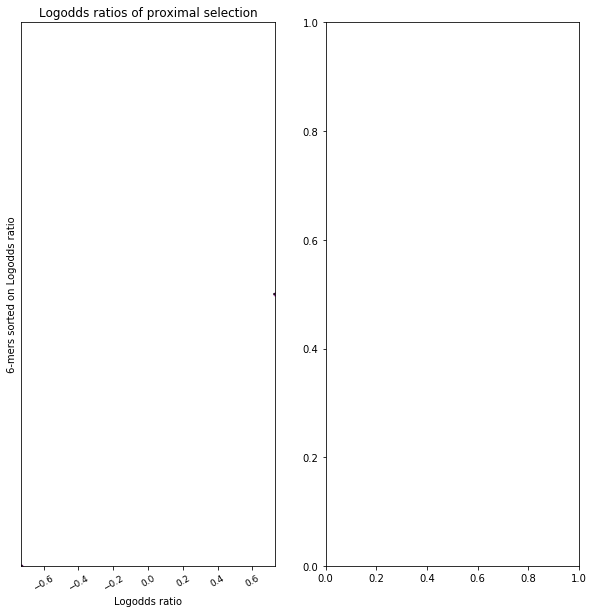

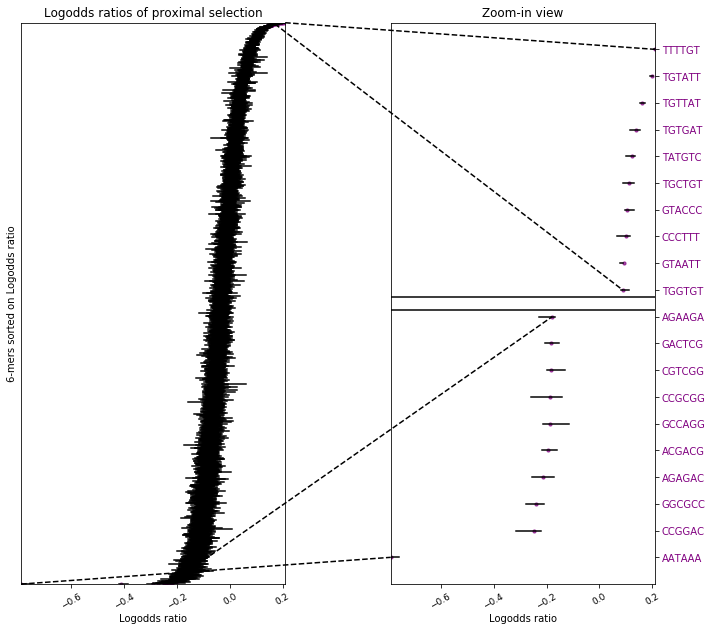

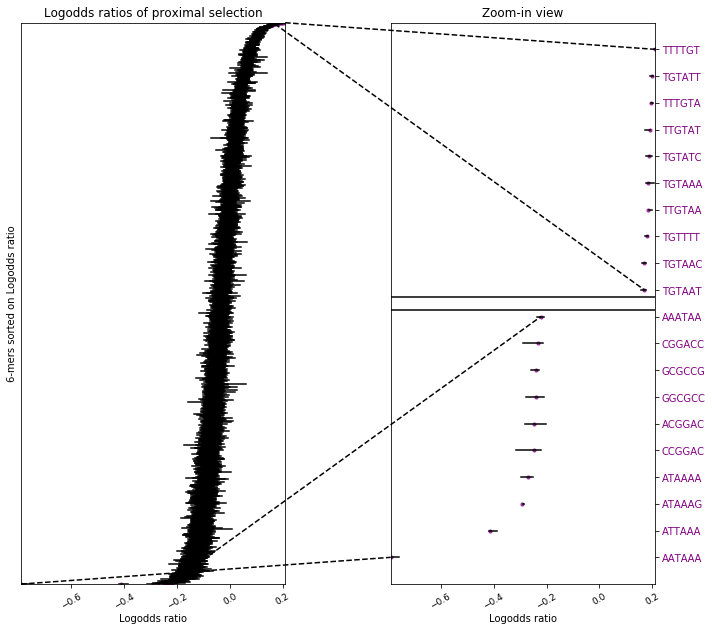

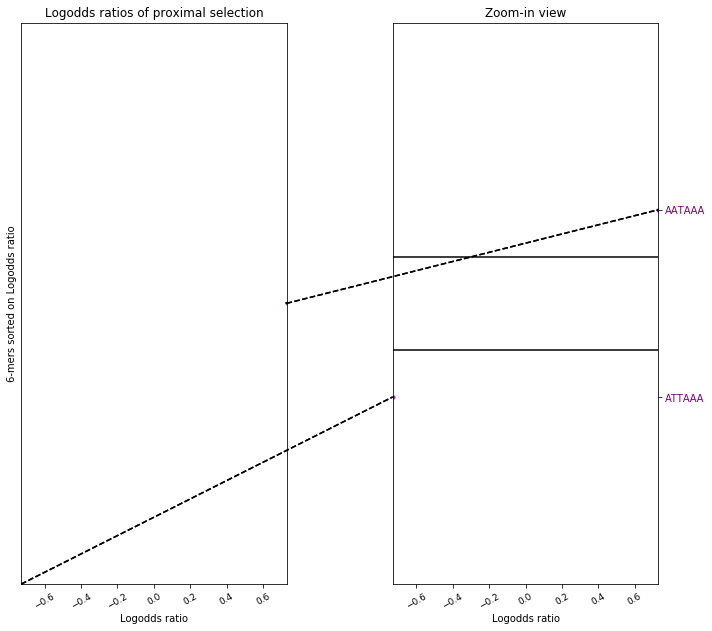

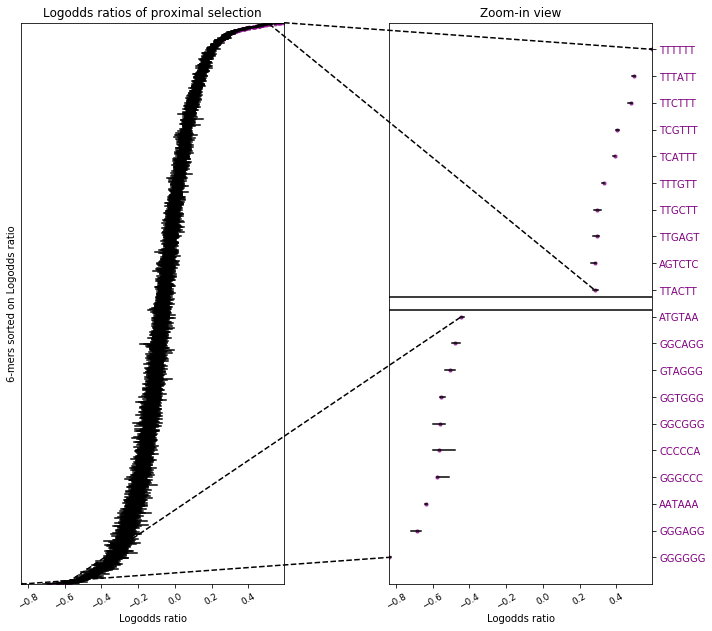

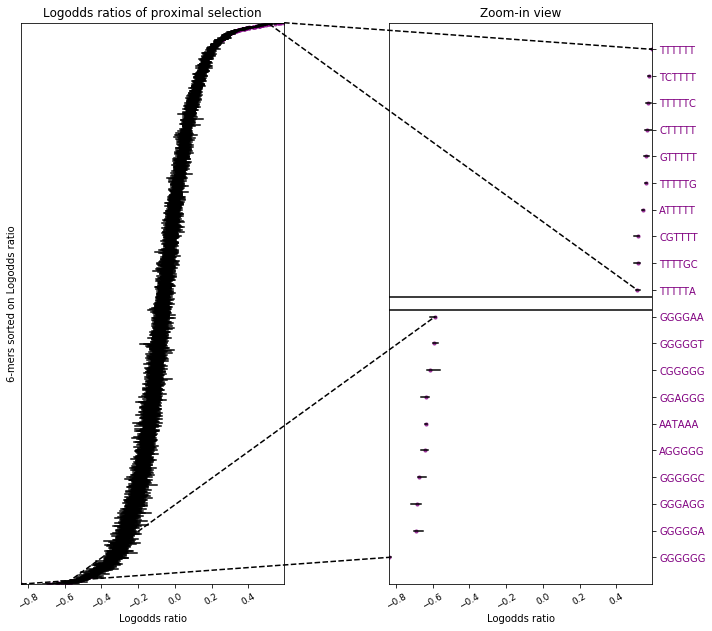

In [19]:
#All libraries
#Upstream
plot_logodds_ratios(w_upstream, w_upstream_bootstrap, 'simple_upstream_6mers_unique4mer', unique4mer=True)
plot_logodds_ratios(w_upstream, w_upstream_bootstrap, 'simple_upstream_6mers', unique4mer=False)

#PAS
plot_logodds_ratios(w_pas, w_pas_bootstrap, 'simple_pas_6mers')

#Downstream
plot_logodds_ratios(w_downstream, w_downstream_bootstrap, 'simple_downstream_6mers_unique4mer', unique4mer=True)
plot_logodds_ratios(w_downstream, w_downstream_bootstrap, 'simple_downstream_6mers', unique4mer=False)